In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from transformers import AutoTokenizer, DistilBertModel
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import time

In [2]:
# create a simple torch model with 1 fully connected layer

class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 2)

    def forward(self, x):
        # apply relu on the output of the fully connected layer
        # x = F.relu(self.fc1(x))
        x = self.fc1(x)
        return x

In [7]:
# load api key from secrets.json
import openai
import json

try:
    with open("secrets.json") as f:
        secrets = json.load(f)
    my_api_key = secrets["openai"]
    print("API key loaded.")
    openai.api_key = my_api_key
except FileNotFoundError:
    print("Secrets file not found. YOU NEED THEM TO RUN THIS.")

API key loaded.


In [8]:
# create timestamp
timestamp = time.strftime("%Y-%m-%d-%H%M")
print(f"Timestamp: {timestamp}")

Timestamp: 2023-12-15-0501


### ✋ Change the classification here ↓

In [9]:
# 'animals', 'art', 'cities', 'clinical'
classification = 'clinical'

## ❗️ (Final paper) Skip until "Resume here"

## Create dataset

In [ ]:
prompt = f"Please generate 300 unique {classification}. The output MUST ONLY be a Python list of strings."
# prompt = f"Please generate 300 unique {classification} words. Please include the most common and familiar instances. The output MUST ONLY be a Python list of the words."

In [ ]:
# model_num = "gpt-3.5-turbo-1106"
# model_num = "gpt-4-1106-preview"
model_num = "gpt-4"

completion = openai.ChatCompletion.create(
  model=model_num,
  messages=[
    {"role": "system", "content": "You are an expert category word generator."},
    {"role": "user", "content": prompt},
  ]
)

print(completion.choices[0].message)

# log the stringified output into a txt file by appending it to the end of the file
# with open("output.txt", "a") as f:
#   f.write(str(completion))

In [ ]:
words = eval(completion.choices[0].message.content)

# make sure that the output is a list of words
print(words)
print(words[0])

['Lion', 'Tiger', 'Elephant', 'Cheetah', 'Leopard', 'Giraffe', 'Hippopotamus', 'Rhino', 'Zebra', 'Gorilla', 'Chimpanzee', 'Koala', 'Kangaroo', 'Penguin', 'Panda', 'Grizzly', 'Polar Bear', 'Otter', 'Seal', 'Walrus', 'Whale', 'Dolphin', 'Shark', 'Octopus', 'Starfish', 'Squid', 'Clam', 'Lobster', 'Crab', 'Shrimp', 'Jellyfish', 'Tuna', 'Salmon', 'Trout', 'Catfish', 'Barracuda', 'Stingray', 'Eel', 'Swordfish', 'Piranha', 'Flamingo', 'Ostrich', 'Peacock', 'Swan', 'Falcon', 'Eagle', 'Hawk', 'Owl', 'Hummingbird', 'Parrot', 'Canary', 'Duck', 'Goose', 'Pigeon', 'Spoonbill', 'Puffin', 'Pelican', 'Heron', 'Sparrow', 'Finch', 'Kingfisher', 'Kookaburra', 'Dove', 'Cuckoo', 'Woodpecker', 'Toucan', 'Albatross', 'Seagull', 'Crow', 'Raven', 'Magpie', 'Jay', 'Hedgehog', 'Badger', 'Beaver', 'Squirrel', 'Raccoon', 'Chipmunk', 'Rat', 'Mouse', 'Hamster', 'Rabbit', 'Mongoose', 'Meerkat', 'Skunk', 'Weasel', 'Otter', 'Chinchilla', 'Fox', 'Wolf', 'Coyote', 'Hyena', 'Bison', 'Buffalo', 'Yak', 'Moose', 'Elk', 'Rein

In [ ]:
# change all strings to lowercase
words = [x.lower() for x in words]

print(words)

['lion', 'tiger', 'elephant', 'cheetah', 'leopard', 'giraffe', 'hippopotamus', 'rhino', 'zebra', 'gorilla', 'chimpanzee', 'koala', 'kangaroo', 'penguin', 'panda', 'grizzly', 'polar bear', 'otter', 'seal', 'walrus', 'whale', 'dolphin', 'shark', 'octopus', 'starfish', 'squid', 'clam', 'lobster', 'crab', 'shrimp', 'jellyfish', 'tuna', 'salmon', 'trout', 'catfish', 'barracuda', 'stingray', 'eel', 'swordfish', 'piranha', 'flamingo', 'ostrich', 'peacock', 'swan', 'falcon', 'eagle', 'hawk', 'owl', 'hummingbird', 'parrot', 'canary', 'duck', 'goose', 'pigeon', 'spoonbill', 'puffin', 'pelican', 'heron', 'sparrow', 'finch', 'kingfisher', 'kookaburra', 'dove', 'cuckoo', 'woodpecker', 'toucan', 'albatross', 'seagull', 'crow', 'raven', 'magpie', 'jay', 'hedgehog', 'badger', 'beaver', 'squirrel', 'raccoon', 'chipmunk', 'rat', 'mouse', 'hamster', 'rabbit', 'mongoose', 'meerkat', 'skunk', 'weasel', 'otter', 'chinchilla', 'fox', 'wolf', 'coyote', 'hyena', 'bison', 'buffalo', 'yak', 'moose', 'elk', 'rein

In [ ]:
# remove duplicates
words = list(set(words))

print(len(words))

# assert len(list(set(words))) == len(words)

290


In [ ]:
non_words = [
    "run", "jump", "eat", "sleep", "think", "happy", "fast", "slow", "beautiful", "smart",
    "quickly", "easily", "always", "never", "under", "over", "beside", "between", "through", "with",
    "and", "but", "or", "because", "although", "well", "yes", "no", "oh", "wow", "ouch",
    "go", "come", "stop", "start", "win", "lose", "hot", "cold", "loud", "soft",
    "bright", "dark", "high", "low", "near", "far", "big", "small", "old", "new",
    "first", "last", "next", "previous", "good", "bad", "happy", "sad", "rich", "poor",
    "early", "late", "hard", "easy", "simple", "complex", "right", "wrong", "true", "false",
    "up", "down", "in", "out", "on", "off", "up", "down", "here", "there",
    "now", "then", "today", "tomorrow", "yesterday", "soon", "later", "before", "after", "while",
    "once", "twice", "thrice", "nevertheless", "however", "suddenly", "finally", "quickly", "slowly", "nowadays",
    "some", "many", "few", "most", "none", "all", "each", "every", "somebody", "nobody",
    "something", "nothing", "somewhere", "nowhere", "anywhere", "everywhere", "this", "that", "these", "those",
    "which", "what", "who", "whom", "whose", "where", "when", "why", "how", "whether",
    "if", "unless", "because", "since", "although", "though", "while", "before", "after", "when",
    "and", "or", "but", "nor", "for", "so", "yet", "either", "neither", "however"
    "is", "are", "was", "were", "am", "be", "being", "been", "has", "have",
    "had", "do", "does", "did", "doing", "will", "would", "shall", "should", "can",
    "could", "may", "might", "must", "ought", "ain't", "isn't", "aren't", "wasn't", "weren't",
    "hasn't", "haven't", "hadn't", "don't", "doesn't", "didn't", "won't", "wouldn't", "shan't", "shouldn't",
    "can't", "cannot", "couldn't", "mayn't", "mightn't", "mustn't", "oughtn't", "it's", "that's", "who's",
    "what's", "there's", "here's", "when's", "where's", "why's", "how's", "not", "no", "never",
    "none", "nope", "nothing", "nowhere", "nobody", "notwithstanding", "however", "although", "though", "but",
    "yet", "either", "neither", "nor", "or", "and", "also", "more", "less", "most",
    "least", "very", "too", "so", "such", "just", "only", "quite", "almost", "even",
    "well", "better", "best", "worse", "worst", "moreover", "furthermore", "nevertheless", "nonetheless", "however",
    "therefore", "consequently", "thus", "hence", "since", "because", "although", "though", "if", "unless",
    "until", "while", "when", "where", "after", "before", "because", "since", "if", "unless",
    "until", "while", "when", "where", "after", "before", "if", "unless", "while", "when",
    "where", "after", "before", "though", "although", "because", "since", "while", "when", "where",
    "if", "unless", "until", "though", "although", "because", "since", "so", "that", "if",
    "unless", "until", "while", "when", "where", "after", "before", "if", "unless", "until",
    "while", "when", "where", "after", "before", "but", "and", "or", "as", "if",
    "unless", "until", "while", "when", "where", "after", "before", "but", "and", "or",
    "as", "because", "since", "so", "that", "if", "unless", "until", "though", "although",
    "because", "since", "while", "when", "where", "if", "unless", "until", "though", "although",
    "because", "since", "so", "that", "if", "unless", "until", "though", "although", "because",
    "since", "while", "when", "where", "after", "before", "if", "unless", "until", "though",
    "although", "because", "since", "so", "that", "if", "unless", "until", "while", "when",
    "where", "after", "before", "though", "although", "because", "since", "so", "that", "if",
    "unless", "until", "while", "when", "where", "after", "before", "but", "and", "or",
    "as", "because", "since", "so", "that", "if", "unless", "until", "though", "although",
    "because", "since", "while", "when", "where", "if", "unless", "until", "though", "although",
    "because", "since", "so", "that", "if", "unless", "until", "though", "although", "because"
    ",", "Wa", "--", ";", ":", "...", "-", ".", "?", "!", "'", "#", "``", "`", "$", "US$", "C$", "and", "or",
    "But", "but", "million", "billion", "one", "two", "10", "the", "a", "The", "an", "this", "there", "There",
    "Perestroika", "besuboru", "de", "etc.", "of", "for", "on", "new", "other", "last", "many", "higher", "lower",
    "largest", "least", "latest", "best", "1", "2", "3", "4", "5", "will", "would", "could", "can", "may", "all",
    "such", "half", "Such", "All", "Word", "it", "he", "they", "I", "It", "its", "their", "his", "her", "our",
    "n't", "also", "not", "only", "even", "more", "earlier", "less", "better", "longer", "most", "Most", "up",
    "out", "off", "in", "down", "&", "to", "To", "TO", "OK", "Oh", "no", "watch", "haul", "extinguish", "hold",
    "chill", "eat", "surf", "devour", "drive", "sail", "descend", "glide", "throw", "carry", "dine", "call",
    "soar", "walk", "sip", "rinse", "uncork", "skate", "type", "read", "bake", "poke", "consume", "fly", "fasten",
    "hit", "flush", "peel", "dry", "crave", "ride", "sit", "indulge", "chop", "be", "make", "buy", "take", "said",
    "was", "were", "had", "did", "cooling", "heating", "including", "according", "being", "growing", "trying",
    "been", "expected", "made", "compared", "based", "are", "have", "say", "do", "re", "is", "has", "says", "s",
    "does", "which", "that", "That", "THAT", "who", "what", "What", "whom", "Who", "whose", "when", "where", "how",
    "When", "why",
    "apple", "book", "car", "dog", "cat", "house", "tree", "friend", "time", "money",
    "heart", "sun", "moon", "sky", "water", "fire", "earth", "flower", "city", "music",
    "child", "parent", "school", "job", "love", "smile", "day", "night", "star", "cloud",
    "bird", "fish", "food", "computer", "phone", "internet", "coffee", "tea", "shoes", "hat",
    "dream", "goal", "team", "game", "hope", "fear", "joy", "anger", "peace", "war",
    "friendship", "family", "health", "beauty", "knowledge", "power", "nature", "history", "science",
    "art", "happiness", "sadness", "color", "mind", "body", "soul", "memory", "experience", "idea",
    "faith", "truth", "lie", "problem", "solution", "question", "answer", "light", "darkness", "wind",
    "rain", "snow", "smell", "taste", "touch", "sound", "silence", "joy", "freedom", "future",
    "past", "present", "purpose", "journey", "adventure", "discovery", "challenge", "victory", "defeat"
    "time", "person", "year", "way", "day", "man", "government", "company", "number", "child",
    "part", "place", "case", "group", "problem", "fact", "eye", "friend", "charge", "point",
    "home", "hand", "job", "food", "example", "place", "book", "end", "government", "water",
    "room", "mother", "area", "money", "story", "fact", "month", "lot", "right", "study",
    "face", "word", "business", "question", "school", "reason", "air", "mind", "law", "company",
    "word", "number", "order", "example", "market", "name", "door", "value", "position", "body",
    "problem", "theory", "class", "child", "car", "house", "year", "arm", "lot", "father",
    "word", "team", "result", "school", "name", "line", "place", "end", "government", "oil",
    "line", "end", "fire", "company", "example", "name", "water", "person", "home", "country",
    "industry", "back", "mother", "house", "name", "side", "period", "city", "case", "job",
    "air", "team", "problem", "name", "number", "part", "car", "hand", "body", "example",
    "home", "water", "point", "name", "company", "room", "group", "fact", "eye", "lot",
    "question", "place", "government", "word", "end", "number", "problem", "part", "home",
    "case", "job", "lot", "team", "person", "result", "line", "city", "air", "example",
    "water", "place", "number", "name", "door", "money", "team", "word", "person", "end",
    "position", "body", "fire", "problem", "car", "word", "house", "value", "fact", "theory",
    "breeze", "cascade", "serenity", "quasar", "equinox", "fluke", "havoc", "gadget", "nuance", "oblivion",
    "paradox", "quagmire", "reverie", "saga", "thistle", "vortex", "whimsy", "xenon", "yarn", "zenith",
    "clique", "dynamo", "epoch", "fiasco", "glyph", "halo", "icon", "jargon", "kaleidoscope", "labyrinth",
    "memento", "nirvana", "opulence", "pinnacle", "quintessence", "rendezvous", "sonnet", "tryst", "utopia", "vista",
    "wanderlust", "xylophone", "yearning", "zealot", "albatross", "bivouac", "catalyst", "dystopia", "effigy", "fandango",
    "companion", "toast", "lounge", "combination", "majesty", "nutrient", "bark", "rest", "drainage", "time", "drink",
    "journey", "shipment", "measure", "cutlery", "catch", "flutter", "moo", "commute", "score", "indulgence", "cutting",
    "containment", "communication", "transportation", "slice", "drying", "tote", "nurture", "breakfast", "cut", "brush",
    "competition", "signal", "mobility", "conformity", "comfort", "pause", "input", "hygiene", "click", "health",
    "entertainment", "halt", "crunch", "softness", "control", "loyalty", "formality", "individuality", "gallop",
    "protection", "gathering", "pattern", "productivity", "purr", "decoration", "bite", "accessory", "reflection",
    "grace", "support", "scoop", "tick", "flight", "navigation", "descent", "voyage", "thrill", "hug", "knowledge",
    "shield", "transit", "solitude", "heat", "celebration", "adventure", "song", "elegance", "recreation", "roar",
    "trumpet", "container", "aroma", "childhood", "measurement", "sanitation", "vibration", "growth", "safety", "swing",
    "sharpness", "stride", "graze", "excitement", "acidity", "prong", "munch", "person", "bicycle", "car", "motorcycle",
    "airplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
    "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove",
    "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch",
    "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone",
    "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear",
    "hair drier", "toothbrush", "%", "company", "year", "market", "trading", "Thanksgiving", "Mr.", "U.S.", "New",
    "Corp.", "York", "Containers", "Securities", "Industries", "Materials", "Soviets", "years", "shares", "prices",
    "cents", "funds"
]

# remove duplicates
non_words = list(set(non_words))

print(len(non_words))


731


In [ ]:
# force remove words in words from non_words
non_words = list(set(non_words) - set(words))

print(len(non_words))

723


In [ ]:
# shuffle non_words
np.random.shuffle(non_words)

# take the same number of non_words as words
non_words = non_words[:len(words)]

print(len(non_words))
print(non_words)

290
['cutting', 'story', 'input', 'tryst', '&', 'bark', 'how', 'icon', 'transportation', "hasn't", 'paradox', 'air', 'frisbee', 'even', 'body', 'far', 'heating', 'yes', 'victory', 'coffee', 'including', 'companion', 'dynamo', 'banana', 'one', 'ouch', 'U.S.', 'protection', 'oil', 'cut', 'Who', 'rain', 'old', 'nuance', 'cell phone', 'whether', 'were', 'thistle', 'either', 'too', '$', 'over', 'music', 'It', 'that', 'team', 'internet', 'clique', 'hope', 'once', '%', 'broccoli', "didn't", 'water', 'drive', 'clock', 'made', 'de', 'what', '``', 'love', 'case', 'howeveris', 'industry', 'remote', 'devour', "who's", 'history', 'beautiful', 'surfboard', 'buy', 'say', 'touch', 'day', 'sun', 'happiness', 'bake', 'nature', 'hygiene', '...', 'do', 'future', 'study', 'support', 'big', 'nothing', 'bed', 'tv', "when's", 'entertainment', 'make', 'joy', 'such', 'sharpness', 'longer', "wouldn't", 'somewhere', 'havoc', 'container', 'snow', 'To', 'flower', 'am', 'has', 'wind', 'Corp.', 'yet', 'thrice', '1', 

## Tokenize and create DistilBERT embeddings - Adapted for Contextualization

1. Contextualization: Get context sentences from API calls

In [ ]:
from openai import OpenAI
import ast

In [ ]:
client = OpenAI(
    api_key= my_api_key,
)

def generateSentences(words, model = 'gpt-4'):
  chat_completion = client.chat.completions.create(
      messages=[{"role": "user", "content": f"For the list of {len(words)} words provided, create an example sentence for each word. Each sentence should incorporate its corresponding word in a manner that highlights its unique usage, illustrating specific behaviors, traits, or characteristics associated with that word. \nWord List: {words}. \nPlease format the output as a Python list, with sentences arranged in the same order as their respective words in the provided list. Do not use any special characters to highlight the word."}],
      model = model
  )
  sentences = chat_completion.choices[0].message
  return sentences

def split_list(words, k):
    return [words[i:i + k] for i in range(0, len(words), k)]

In [ ]:
# put your word list here
words_all = [
    'New York', 'London', 'Tokyo', 'Paris', 'Shanghai', 'Beijing', 'Los Angeles',
    'Hong Kong', 'Mumbai', 'Chicago', 'Singapore', 'Seoul', 'Dubai', 'Moscow',
    'São Paulo', 'Toronto', 'San Francisco', 'Sydney', 'Istanbul', 'Amsterdam',
    'Mexico City', 'Madrid', 'Berlin', 'Bangkok', 'Rio de Janeiro', 'Buenos Aires',
    'Johannesburg', 'Delhi', 'Cairo', 'Barcelona', 'Rome', 'Milan', 'Miami',
    'Kuala Lumpur', 'Jakarta', 'Manila', 'Lagos', 'Taipei', 'Brussels', 'Stockholm',
    'Vienna', 'Melbourne', 'Athens', 'Montreal', 'Tel Aviv', 'Zurich', 'Copenhagen',
    'Vancouver', 'Dublin', 'Helsinki', 'Lisbon', 'Prague', 'Oslo', 'Warsaw',
    'Budapest', 'Bangkok', 'Caracas', 'Santiago', 'Doha', 'Riyadh', 'Kuwait City',
    'Bengaluru', 'Chennai', 'Pune', 'Kolkata', 'Ho Chi Minh City', 'Hanoi', 'Karachi',
    'Dhaka', 'Colombo', 'Nairobi', 'Dar es Salaam', 'Addis Ababa', 'Accra',
    'Casablanca', 'Algiers', 'Tunis', 'Harare', 'Luanda', 'Perth', 'Brisbane',
    'Auckland', 'Wellington', 'Edmonton', 'Calgary', 'Ottawa', 'Quebec City',
    'Halifax', 'Anchorage', 'Honolulu', 'Las Vegas', 'Phoenix', 'Atlanta',
    'Houston', 'Boston', 'Detroit', 'Philadelphia', 'Dallas', 'Seattle', 'Minneapolis'
]

In [ ]:
# split the word list into multiple chunks each of size 'chunk_size'
chunk_size = 10 # you can replace it with any size that you may like
words_list = split_list(words_all, chunk_size)

In [ ]:
sentences_all = []
for i, words in enumerate(words_list):
    print(f'Word chunk{i}')
    res = generateSentences(words)
    sentences = ast.literal_eval(res.content)
    for word, sentence in zip(words, sentences): # print the word-sentence pairs just to make sure that there is no weird output
        print('Word:', word)
        print('Sentence:', sentence)
    sentences_all.extend(sentences)

Word chunk0
Word: New York
Sentence: She spent her youth hopping between art shows and high-profile parties in New York.
Word: London
Sentence: As an ardent fan of royalty and history, Stanley dreamed of visiting London's majestic palaces and museums.
Word: Tokyo
Sentence: Tokyo's bustling metro and towering skyscrapers left him in awe of its advanced technology and fast-paced lifestyle.
Word: Paris
Sentence: In Paris, she found herself enthralled by the enchanting blend of classic architecture and modern style.
Word: Shanghai
Sentence: After landing a job with a major multinational, he moved to Shanghai, China's dynamic financial hub.
Word: Beijing
Sentence: In Beijing, preparations were underway for the colossal national celebration in Tiananmen Square.
Word: Los Angeles
Sentence: The dream of becoming a successful movie star drew thousands to Los Angeles every year.
Word: Hong Kong
Sentence: Riding the Star Ferry, he marveled at the towering skyline of Hong Kong glittering in the ni

2. Encoding: Extract DistilBERT embeddings of the word from contextualized input

In [ ]:
from transformers import AutoTokenizer, DistilBertModel
import torch

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

In [ ]:
def getEmbedding(input_text, word):
    encoded_input = tokenizer(input_text, return_tensors='pt')
    with torch.no_grad():
        output = model(**encoded_input)
    token_embeddings = output.last_hidden_state
    token_ids_word = tokenizer.encode(word, add_special_tokens=False)
    word_token_positions = []
    for i in range(len(encoded_input['input_ids'][0]) - len(token_ids_word) + 1):
        if encoded_input['input_ids'][0][i:i + len(token_ids_word)].tolist() == token_ids_word:
            word_token_positions.extend(range(i, i + len(token_ids_word)))
    if not word_token_positions:
        print(f"no found.")
        return None
    # Calculate the mean of the embeddings for the tokens corresponding to the word if consists of multiple tokens
    word_embedding = token_embeddings[0, word_token_positions, :].mean(dim=0)
    # Retrieve and print the tokens for the word to make sure that there's no weird output
    retrieved_tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0][word_token_positions])
    print(f"Original word: {word}")
    print(f"Tokens: {retrieved_tokens}")

    return word_embedding


In [ ]:
embeddings = []
for word, sentence in zip(words_all,sentences_all):
    emb = getEmbedding(sentence, word)
    embeddings.append(emb)

Original word: New York
Tokens: ['new', 'york']
Original word: London
Tokens: ['london']
Original word: Tokyo
Tokens: ['tokyo']
Original word: Paris
Tokens: ['paris']
Original word: Shanghai
Tokens: ['shanghai']
Original word: Beijing
Tokens: ['beijing']
Original word: Los Angeles
Tokens: ['los', 'angeles']
Original word: Hong Kong
Tokens: ['hong', 'kong']
Original word: Mumbai
Tokens: ['mumbai']
Original word: Chicago
Tokens: ['chicago']
Original word: Singapore
Tokens: ['singapore']
Original word: Seoul
Tokens: ['seoul']
Original word: Dubai
Tokens: ['dubai']
Original word: Moscow
Tokens: ['moscow']
Original word: São Paulo
Tokens: ['sao', 'paulo']
Original word: Toronto
Tokens: ['toronto']
Original word: San Francisco
Tokens: ['san', 'francisco']
Original word: Sydney
Tokens: ['sydney', 'sydney']
Original word: Istanbul
Tokens: ['istanbul']
Original word: Amsterdam
Tokens: ['amsterdam']
Original word: Mexico City
Tokens: ['mexico', 'city']
Original word: Madrid
Tokens: ['madrid']
Or

In [ ]:
# confirm that the words and embeddings are of correct size
words = words_all
print(len(words)) # should be 100
print(len(embeddings)) # should be 100
print(embeddings[0].shape) # should be 768

100
100
torch.Size([768])


In [ ]:
# save the embeddings for sharing
import pickle

classification = 'cities' # modify this to reflect your topic
word_file_name = classification + '_words.pkl'
emb_file_name = classification + '_embeddings.pkl'

# saving to a pickle file for sharing
with open(word_file_name, 'wb') as file:
    pickle.dump(words, file)

with open(emb_file_name, 'wb') as file:
    pickle.dump(embeddings, file)

In [ ]:
# you can use the code to load this variable back to confirm it's working
with open(word_file_name, 'rb') as file:
   loaded_words = pickle.load(file)

with open(emb_file_name, 'rb') as file:
   loaded_emb = pickle.load(file)

## ❗️ (Final paper) Resume here!

### read in final dataset and get subset for specific category experiment

In [10]:
import pandas as pd

# read the csv file back in to confirm it's working
df = pd.read_csv('data/final_data.csv')

print(df.shape) # should be (400, 770) because 768 axes + 2 columns for category and word
df.head()

(400, 770)


,category,word,0,1,2,3,4,5,6,7,...,758,759,760,761,762,763,764,765,766,767
0,animals,aardvark,0.219,0.310,-0.013,-0.170,0.551,-0.316,0.321,0.273,...,-0.137,0.102,-0.164,-0.275,-0.076,-0.162,-0.400,0.018,0.503,-0.134
1,animals,albatross,-0.086,0.124,-0.116,0.331,0.347,-0.345,-0.268,0.695,...,-0.402,-0.002,-0.062,-0.463,-0.352,-0.062,-0.630,-0.384,0.620,-0.327
2,animals,alligator,0.298,0.271,-0.630,0.118,0.723,0.064,-0.072,0.493,...,-0.176,0.045,-0.197,0.076,-0.504,0.056,0.023,-0.073,0.084,-0.309
3,animals,alpaca,0.022,-0.271,-0.243,0.037,0.653,0.193,0.433,0.714,...,-0.622,0.082,0.159,-0.423,-0.331,-0.031,0.102,-0.387,0.191,-0.090
4,animals,ant,0.337,0.297,-0.349,-0.122,0.578,0.435,0.400,0.463,...,-0.106,0.013,-0.226,0.118,-0.317,0.095,-0.273,-0.024,0.394,0.058


In [11]:
category = classification # modify this to reflect your topic

# get all rows with category
df_category = df[df['category'] == category]

# randomly sample 100 rows from rows where category != category
df_other = df[df['category'] != category].sample(n=100)

# combine the two dfs into one
df_final = pd.concat([df_category, df_other])

print(df_final.shape) # should be (200, 770)
# df_final.tail()

# count the number of words in each category
df_final['category'].value_counts()

(200, 770)


clinical    100
art          36
animals      32
cities       32
Name: category, dtype: int64

### Train / Test Split

In [12]:
# get category words and embeddings
words = df_category['word'].tolist()
embeddings = df_category.iloc[:, 2:].values.tolist()

# get non-category words and embeddings
non_words = df_other['word'].tolist()
non_embeddings = df_other.iloc[:, 2:].values.tolist()


In [13]:
# slice the lists into training and test sets
words_train = words[:int(len(words)*0.8)]
words_test = words[int(len(words)*0.8):]
embeddings_train = embeddings[:int(len(embeddings)*0.8)]
embeddings_test = embeddings[int(len(embeddings)*0.8):]

non_words_train = non_words[:int(len(non_words)*0.8)]
non_words_test = non_words[int(len(non_words)*0.8):]
non_embeddings_train = non_embeddings[:int(len(non_embeddings)*0.8)]
non_embeddings_test = non_embeddings[int(len(non_embeddings)*0.8):]

# create a dataframe with the training sets
train_embeddings = embeddings_train + non_embeddings_train
df_train = pd.DataFrame(train_embeddings)
# convert the column names to strings
df_train.columns = [str(i) for i in df_train.columns]

df_train['label'] = [1]*len(words_train) + [0]*len(non_words_train)
df_train['word'] = words_train + non_words_train

# create a dataframe with the test sets
test_embeddings = embeddings_test + non_embeddings_test
df_test = pd.DataFrame(test_embeddings)
# convert the column names to strings
df_test.columns = [str(i) for i in df_test.columns]

df_test['label'] = [1]*len(words_test) + [0]*len(non_words_test)
df_test['word'] = words_test + non_words_test

print(df_train[:5])
print(df_train[-5:])
print(df_test[:5])
print(df_test[-5:])

       0      1      2      3      4      5      6      7      8      9  ...  \
0 -0.447  0.162  0.237 -0.156  0.491  0.045  0.169  0.741 -0.217 -0.030  ...   
1 -0.046 -0.148  0.014 -0.243  0.810 -0.015  0.001  0.822 -0.395  0.098  ...   
2  0.082  0.705 -0.157  0.158  0.753 -0.088  0.308  0.707  0.553 -0.116  ...   
3 -0.298 -0.347  0.195 -0.407  0.570  0.214  0.280  0.774 -0.490 -0.001  ...   
4  0.395  0.540 -0.394 -0.208  0.150  0.047  0.334  0.215  0.018  0.252  ...   

     760    761    762    763    764    765    766    767  label          word  
0  0.214 -0.613  0.145  0.051 -0.504 -0.164 -0.109  0.020      1  hypertension  
1  0.670  0.204  0.004  0.060 -0.704 -0.253 -0.110  0.242      1  cardiomegaly  
2  0.012 -0.395  0.415 -0.095 -0.192 -0.014 -0.159  0.072      1         yeast  
3  0.423  0.065  0.045 -0.151 -0.734 -0.154 -0.005  0.148      1    hemiplegia  
4 -0.103 -0.792 -0.410  0.264 -0.176 -0.506 -0.184 -0.229      1    psychiatry  

[5 rows x 770 columns]
         

## Train the model for 1-axis slices

In [14]:
class CustomDataset(Dataset):
    def __init__(self, tokenized_texts, labels):
        self.tokenized_texts = torch.tensor(tokenized_texts)
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.tokenized_texts[idx], self.labels[idx]

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('mps')
# device = torch.device('cpu')

In [16]:
def create_dataloaders(df_train, df_test):
    train_dataset = CustomDataset(df_train['embedding'], df_train['label'])
    test_dataset = CustomDataset(df_test['embedding'], df_test['label'])

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

    return train_loader, test_loader

In [17]:
def train_model(train_loader, input_size):

    # train the model
    net = Net(input_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.003)

    num_epochs = 100
    net.to(device)

    best_combined_loss = float('inf')

    for epoch in range(num_epochs):
        net.train()
        combined_loss = 0
        for batch in train_loader:
            # get data to GPU if possible
            data = batch[0].to(device=device, dtype=torch.float32)
            if len(data.shape) == 1:
                data = data.unsqueeze(1)
            # data = data.unsqueeze(1)
            targets = batch[1].to(device=device)
            # print(data.shape)

            # forward
            scores = net(data)
            loss = criterion(scores, targets)
            combined_loss += loss.item()

            # backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step
            optimizer.step()

        if combined_loss < best_combined_loss:
            best_combined_loss = combined_loss

        # print initial loss
        # if epoch == 0:
        #     print(f'Initial loss: {combined_loss/len(train_loader)}')

        # print average loss per epoch every 10 epochs
        # if (epoch + 1) % 10 == 0:
        #     print(f'Epoch {epoch + 1}, loss={combined_loss/len(train_loader)}')
        #     # print(combined_loss / len(train_loader))

    return net, best_combined_loss

In [18]:
# evaluate the net using sklearn metrics
def evaluate_net(loader, net):
    y_true = []
    y_pred = []

    net.eval()
    with torch.no_grad():
        for batch in loader:
            # get data to GPU if possible
            data = batch[0].to(device=device, dtype=torch.float32)
            if len(data.shape) == 1:
                data = data.unsqueeze(1)
            # data = data.unsqueeze(1)
            targets = batch[1].to(device=device)

            # forward
            scores = net(data)
            _, predictions = scores.max(1)
            y_true.extend(targets.tolist())
            y_pred.extend(predictions.tolist())

    accuracy = accuracy_score(y_true, y_pred)
    # precision = precision_score(y_true, y_pred)
    # recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return accuracy, f1
    # return accuracy, precision, recall, f1

In [19]:
# outputs the probability of the positive class
def output_pos_prob(loader, net):
    y_pos_prob = []

    net.eval()
    with torch.no_grad():
        for batch in loader:
            # get data to GPU if possible
            data = batch[0].to(device=device, dtype=torch.float32)
            if len(data.shape) == 1:
                data = data.unsqueeze(1)
            # data = data.unsqueeze(1)
            # targets = batch[1].to(device=device)

            # forward
            scores = net(data)
            y_pos_prob.extend(F.softmax(scores, dim=1)[:, 1].tolist())

    return y_pos_prob

### ✋ Change number of loop iterations per slice here ↓

In [20]:
num_loop = 10

In [21]:
# go through all the slices of the dataframe and train and evaluate the model

all_test_accs = []
all_test_f1s = []
all_combined_losses = []

for slice in range(768):
    print(f'Slice: {slice}')
    # slice = 0

    # create one column slice of the dataframe
    df_train_slice = pd.DataFrame({
        # 'word': df_train['word'],
        'embedding': df_train[str(slice)],
        'label': df_train['label']
    })

    df_test_slice = pd.DataFrame({
        # 'word': df_test['word'],
        'embedding': df_test[str(slice)],
        'label': df_test['label']
    })

    # print(df_train_slice[:5])
    # print(df_train_slice[-5:])

    train_slice_loader, test_slice_loader = create_dataloaders(df_train_slice, df_test_slice)

    # take the best of 3 runs
    best_test_acc = 0
    best_test_f1 = 0

    for i in range(num_loop):     # takes the best of 10 runs
        net, best_combined_loss = train_model(train_slice_loader, 1)

        # train_acc, train_f1 = evaluate_net(train_slice_loader, net)
        test_acc, test_f1 = evaluate_net(test_slice_loader, net)

        if test_acc > best_test_acc and test_f1 > best_test_f1:
            best_test_acc = test_acc
            best_test_f1 = test_f1
            # best_train_acc = train_acc
            # best_net = net

    all_test_accs.append(best_test_acc)
    all_test_f1s.append(best_test_f1)
    all_combined_losses.append(best_combined_loss)

    # print(f'Accuracy on training set: {check_accuracy(train_loader, net)*100:.2f}%')
    # print(f'Accuracy on test set: {check_accuracy(test_loader, net)*100:.2f}%')

    print(f'Slice {slice} best combined loss: {best_combined_loss}')
    print(f'Slice {slice} best test f1: {best_test_f1:.4f}')
    print(f'Slice {slice} best test accuracy: {best_test_acc*100:.2f}% \n')

print(len(all_test_accs))
# print(len(all_test_f1s))

Slice: 0
Slice 0 best combined loss: 6.463820934295654
Slice 0 best test f1: 0.6667
Slice 0 best test accuracy: 67.50% 

Slice: 1
Slice 1 best combined loss: 6.796404242515564
Slice 1 best test f1: 0.6667
Slice 1 best test accuracy: 67.50% 

Slice: 2
Slice 2 best combined loss: 6.4168203473091125
Slice 2 best test f1: 0.7000
Slice 2 best test accuracy: 70.00% 

Slice: 3
Slice 3 best combined loss: 5.770208090543747
Slice 3 best test f1: 0.6000
Slice 3 best test accuracy: 60.00% 

Slice: 4
Slice 4 best combined loss: 6.209632575511932
Slice 4 best test f1: 0.6829
Slice 4 best test accuracy: 67.50% 

Slice: 5
Slice 5 best combined loss: 6.6931517124176025
Slice 5 best test f1: 0.5000
Slice 5 best test accuracy: 50.00% 

Slice: 6
Slice 6 best combined loss: 6.70559287071228
Slice 6 best test f1: 0.5714
Slice 6 best test accuracy: 62.50% 

Slice: 7
Slice 7 best combined loss: 5.468898236751556
Slice 7 best test f1: 0.7805
Slice 7 best test accuracy: 77.50% 

Slice: 8
Slice 8 best combined 

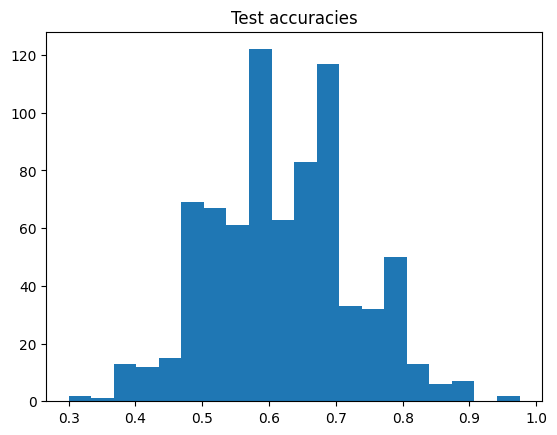

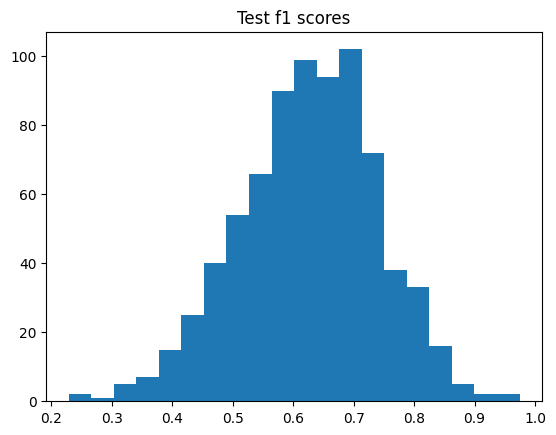

In [22]:
# plot histograms of the test accuracies and f1 scores
plt.hist(all_test_accs, bins=20)
plt.title('Test accuracies')
plt.show()

plt.hist(all_test_f1s, bins=20)
plt.title('Test f1 scores')
plt.show()

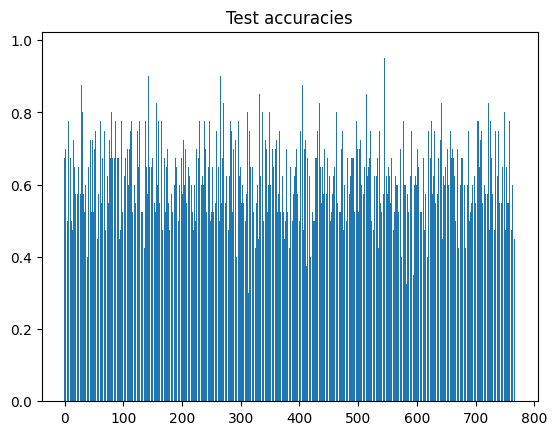

In [23]:
# plot bar chart of the accuracies across all 768 axes
plt.bar(range(768), all_test_accs)
plt.title('Test accuracies')
plt.show()

In [24]:
print(all_test_accs[:10])

[0.675, 0.675, 0.7, 0.6, 0.675, 0.5, 0.625, 0.775, 0.425, 0.55]


In [25]:
# convert list of tensors into list of floats
try:
  all_test_accs_val = [acc.item() for acc in all_test_accs]
  all_test_f1s_val = [f1.item() for f1 in all_test_f1s]
except:
  all_test_accs_val = all_test_accs
  all_test_f1s_val = all_test_f1s

print(all_test_accs_val[:10])
print(all_test_f1s_val[:10])

[0.675, 0.675, 0.7, 0.6, 0.675, 0.5, 0.625, 0.775, 0.425, 0.55]
[0.6666666666666667, 0.6666666666666667, 0.7, 0.6, 0.6829268292682926, 0.5, 0.5714285714285715, 0.7804878048780488, 0.46511627906976744, 0.5]


In [26]:
# convert the lists into numpy arrays
all_test_accs_val = np.array(all_test_accs_val)
all_test_f1s_val = np.array(all_test_f1s_val)
all_combined_losses = np.array(all_combined_losses)

## Identify top 10 axes by accuracy

In [27]:
# find the indices of the top 10 slices
top_10_indices = np.argsort(all_test_accs_val)[-10:]
top_10_indices_f1 = np.argsort(all_test_f1s_val)[-10:]
print("Top 10 indices by accuracy", top_10_indices)
print("Top 10 indices by f1 score", top_10_indices_f1)

# find the metrics of the top 10 axes based on ACCURACY index
print("Accuracy for top 10 (accuracy)", all_test_accs_val[top_10_indices])
print("F1 Scores for top 10 (accuracy)", all_test_f1s_val[top_10_indices])
print("Losses for top 10 (accuracy)", all_combined_losses[top_10_indices])

Top 10 indices by accuracy [714  29 405 733 143 149 445 266 545 607]
Top 10 indices by f1 score [747 733  29 405 445 143 266 149 545 607]
Accuracy for top 10 (accuracy) [0.85  0.875 0.875 0.875 0.9   0.9   0.9   0.9   0.95  0.975]
F1 Scores for top 10 (accuracy) [0.84210526 0.87179487 0.87179487 0.86486486 0.89473684 0.90909091
 0.88888889 0.9047619  0.95       0.97435897]
Losses for top 10 (accuracy) [5.36995217 4.24956714 3.60319415 5.26857436 3.48220754 4.8568424
 4.37899157 5.83466962 5.79653934 3.6483413 ]


In [29]:
# create a dataframe with accuracy and loss across all 768 axes
df_acc_loss = pd.DataFrame({
    'accuracy': all_test_accs_val,
    'f1': all_test_f1s,
    'loss': all_combined_losses
})

print(df_acc_loss[:10])

# save the dataframe to a csv file
df_acc_loss.to_csv(f"llm-outputs/final-outputs/pipeline_1211_{classification}_{timestamp}_acc_loss.csv", index=False)

   accuracy        f1      loss
0     0.675  0.666667  6.463821
1     0.675  0.666667  6.796404
2     0.700  0.700000  6.416820
3     0.600  0.600000  5.770208
4     0.675  0.682927  6.209633
5     0.500  0.500000  6.693152
6     0.625  0.571429  6.705593
7     0.775  0.780488  5.468898
8     0.425  0.465116  6.923338
9     0.550  0.500000  6.528869


## Analysis for top 10 axes

In [30]:
# for each of the top 10 slices,
# average the embeddings of the pro words and the non words
# WHY: to see if there is a larger difference for axes that are more predictive

pro_emb_avg = []
non_emb_avg = []

for i in top_10_indices:
    df_slice = pd.DataFrame({
        # 'word': df_train['word'],
        'embedding': df_train[str(i)],
        'label': df_train['label']
    })

    df_slice_pro = df_slice[df_slice['label'] == 1]
    df_slice_non = df_slice[df_slice['label'] == 0]

    pro_emb_avg.append(np.mean(df_slice_pro['embedding']))
    non_emb_avg.append(np.mean(df_slice_non['embedding']))

# create a dataframe with the average embeddings
df_top10_avg = pd.DataFrame({
    'index': top_10_indices,
    'pro': pro_emb_avg,
    'non': non_emb_avg,
    'diff': abs(np.array(pro_emb_avg) - np.array(non_emb_avg)),
    'acc': all_test_accs_val[top_10_indices],
    'f1': all_test_f1s_val[top_10_indices],
    'loss': all_combined_losses[top_10_indices]
})

print(df_top10_avg)

# save the dataframe to a csv file
df_top10_avg.to_csv(f"llm-outputs/final-outputs/pipeline_1211_{classification}_{timestamp}_top10_metrics.csv", index=False)

   index       pro       non      diff    acc        f1      loss
0    714  0.153550 -0.106675  0.260225  0.850  0.842105  5.369952
1     29 -0.389150  0.059250  0.448400  0.875  0.871795  4.249567
2    405  0.129913 -0.304862  0.434775  0.875  0.871795  3.603194
3    733  0.000337 -0.371450  0.371787  0.875  0.864865  5.268574
4    143  0.786200  0.091663  0.694538  0.900  0.894737  3.482208
5    149  0.335162 -0.030288  0.365450  0.900  0.909091  4.856842
6    445 -0.153062 -0.683250  0.530188  0.900  0.888889  4.378992
7    266 -0.063150  0.198175  0.261325  0.900  0.904762  5.834670
8    545 -0.128175 -0.418588  0.290413  0.950  0.950000  5.796539
9    607 -0.179612  0.289850  0.469462  0.975  0.974359  3.648341


In [31]:
# Plot the histogram of the embedding values for the top 10 axes
# WHY: to see the relationship between the distribution of the positive and negative classes

def plot_axis_hist(slice):
    df_slice = pd.DataFrame({
        # 'word': df_train['word'],
        'embedding': df_train[str(slice)],
        'label': df_train['label']
    })

    df_slice_pro = df_slice[df_slice['label'] == 1]
    df_slice_non = df_slice[df_slice['label'] == 0]

    # draw a histogram of the embeddings, with the pro words in red and the non-pro words in blue
    plt.hist(df_slice_pro['embedding'], bins=30, color='red', alpha=0.5)
    plt.hist(df_slice_non['embedding'], bins=30, color='blue', alpha=0.5)
    plt.title(f"Axis {slice} histogram")
    plt.show()

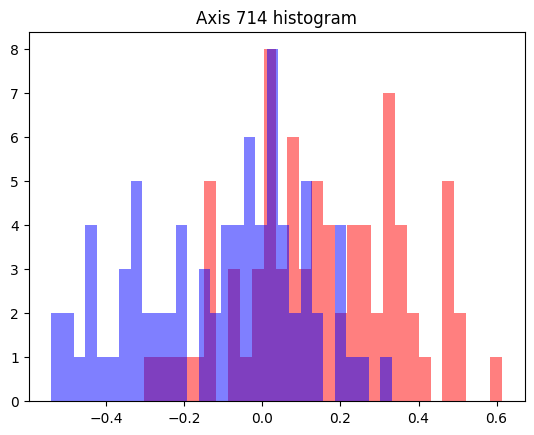

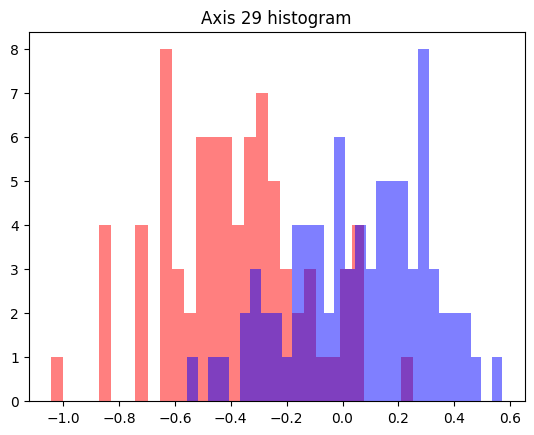

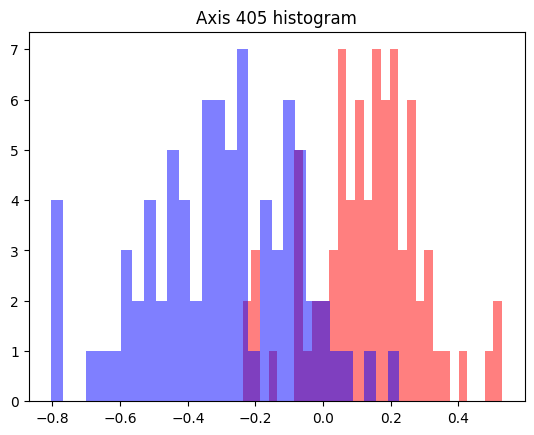

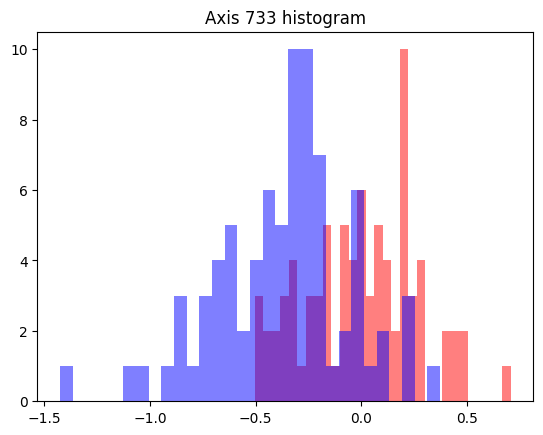

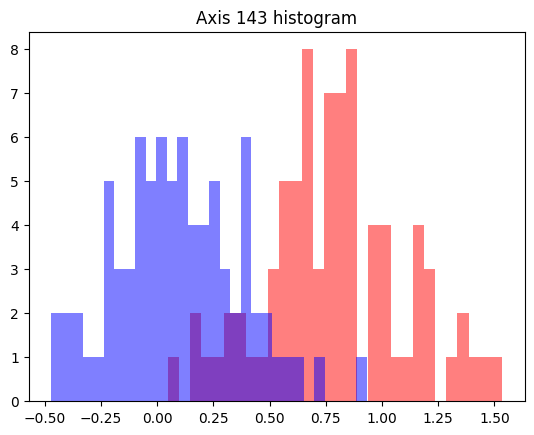

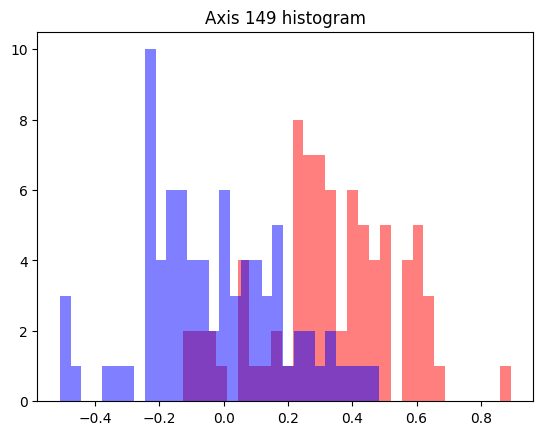

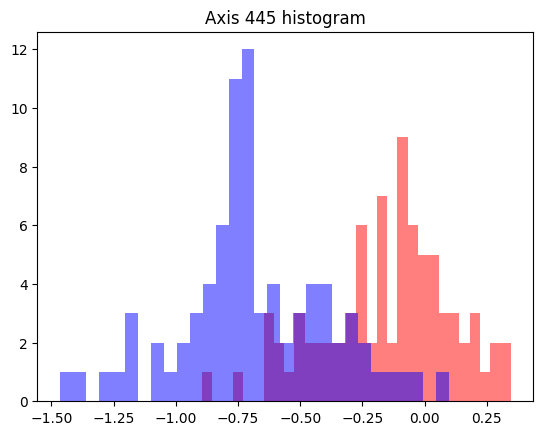

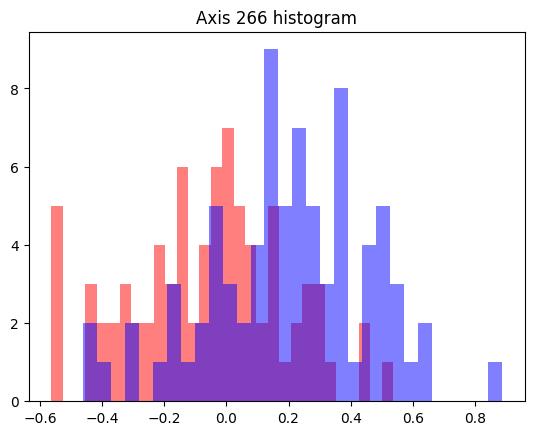

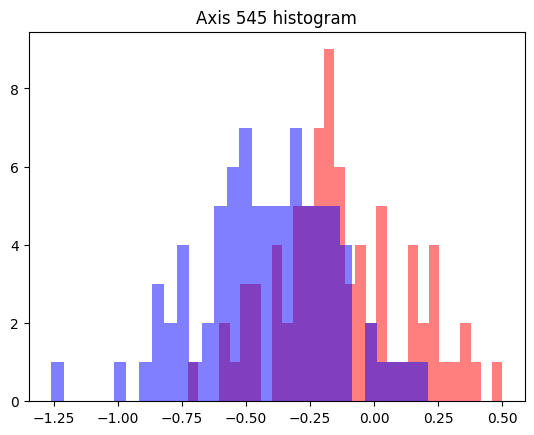

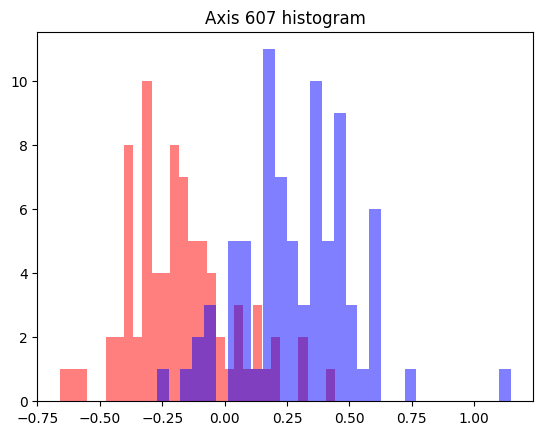

In [32]:
for i in top_10_indices:
    plot_axis_hist(i)

## Evaluate axes at `scale = 5` for test and control conditions

In [33]:
def run_model_on_defined_subslice(condition, subslice, top_or_complement):
    if condition == 'test':
        if top_or_complement:
            subslice_indices = np.argsort(all_test_accs_val)[-subslice:]
            desc = "top"
        else:
            subslice_indices = np.argsort(all_test_accs_val)[:-subslice]
            subslice = 768 - subslice
            desc = "complement"

        df_subslice_train = pd.DataFrame(df_train[str(i)] for i in subslice_indices)
        df_subslice_train = df_subslice_train.T

        # combine all column values into list stored in one column
        df_subslice_train['embedding'] = df_subslice_train.values.tolist()

        # remove all columns except the list of embeddings
        df_subslice_train = df_subslice_train[['embedding']]
        df_subslice_train['label'] = df_train['label']
        df_subslice_train['word'] = df_train['word']

        print(df_subslice_train[:10])
        print(len(df_subslice_train['embedding'][0]))

        df_subslice_test = pd.DataFrame(df_test[str(i)] for i in subslice_indices)
        df_subslice_test = df_subslice_test.T

        # combine all column values into list stored in one column
        df_subslice_test['embedding'] = df_subslice_test.values.tolist()

        # remove all columns except the list of embeddings
        df_subslice_test = df_subslice_test[['embedding']]
        df_subslice_test['label'] = df_test['label']
        df_subslice_test['word'] = df_test['word']

        print(df_subslice_test[:10])
        print(len(df_subslice_test['embedding'][0]))

    elif condition == 'control':
        if top_or_complement:
            desc = "top"

            #create subslice of training df by taking the first subslice columns
            df_subslice_train = pd.DataFrame({
                'embedding': df_train.iloc[:, :subslice].values.tolist(),
                'label': df_train['label'],
                'word': df_train['word']
            })

            #create subslice of test df by taking the first subslice columns
            df_subslice_test = pd.DataFrame({
                'embedding': df_test.iloc[:, :subslice].values.tolist(),
                'label': df_test['label'],
                'word': df_test['word']
            })
        else:
            subslice = 768 - subslice
            desc = "complement"

            #create subslice of training df by taking the last subslice columns
            df_subslice_train = pd.DataFrame({
                'embedding': df_train.iloc[:, (768-subslice):-2].values.tolist(),
                'label': df_train['label'],
                'word': df_train['word']
            })

            #create subslice of test df by taking the last subslice columns
            df_subslice_test = pd.DataFrame({
                'embedding': df_test.iloc[:, (768-subslice):-2].values.tolist(),
                'label': df_test['label'],
                'word': df_test['word']
            })

    subslice_train_loader, subslice_test_loader = create_dataloaders(df_subslice_train, df_subslice_test)

    # take the best of 3 runs
    subslice_best_test_acc = 0
    subslice_best_test_f1 = 0

    for i in range(num_loop):
        net, subslice_best_combined_loss = train_model(subslice_train_loader, subslice)

        # train_acc, train_f1 = evaluate_net(subslice_train_loader, net)
        test_acc, test_f1 = evaluate_net(subslice_test_loader, net)

        if test_acc > subslice_best_test_acc and test_f1 > subslice_best_test_f1:
            subslice_best_test_acc = test_acc
            subslice_best_test_f1 = test_f1

    print(f'{desc} {subslice} axes best combined loss: {subslice_best_combined_loss}')
    print(f'{desc} {subslice} axes best test f1: {subslice_best_test_f1:.4f}')
    print(f'{desc} {subslice} axes best test accuracy: {subslice_best_test_acc*100:.2f}% \n')

    return subslice_best_test_acc, subslice_best_test_f1, subslice_best_combined_loss


In [34]:
# run for full 768 axes
full_acc, full_f1, full_loss = run_model_on_defined_subslice('test', 768, True)

                                           embedding  label          word
0  [0.155, -0.265, -0.187, 0.085, -0.064, -0.39, ...      1  hypertension
1  [-0.178, -0.193, -0.22, -0.149, -0.553, 0.136,...      1  cardiomegaly
2  [-0.52, 0.544, -0.575, -0.442, 0.494, 0.322, -...      1         yeast
3  [0.189, -0.461, -0.195, 0.184, 0.048, -0.272, ...      1    hemiplegia
4  [0.23, 0.335, 0.081, 0.227, -0.028, -0.068, -0...      1    psychiatry
5  [-0.37, 0.326, -0.093, 0.127, -0.24, 0.089, -0...      1   dermatology
6  [-0.24, -0.093, -0.036, -0.012, -0.162, -0.001...      1    hemoglobin
7  [-0.109, -0.072, -0.312, -0.249, -0.393, 0.209...      1          zinc
8  [-0.005, 0.172, -0.291, -0.575, -0.151, -0.325...      1      migraine
9  [0.01, 0.212, -0.237, -0.12, 0.024, -0.47, -0....      1      xanthoma
768
                                           embedding  label           word
0  [-0.013, -0.025, -0.217, 0.215, 0.007, 0.227, ...      1     metastasis
1  [-0.012, 0.322, -0.064, -0.11

In [35]:
# save the metrics to a csv file
df_full = pd.DataFrame({
    'acc': [full_acc],
    'f1': [full_f1],
    'loss': [full_loss]
})

df_full.to_csv(f"llm-outputs/final-outputs/pipeline_1211_{classification}_{timestamp}_768_metrics.csv", index=False)

In [36]:
range_val = 80

In [37]:
def run_defined_subslice_for_scale(condition, scale):
    subslice_top_accs = []
    subslice_top_f1s = []
    subslice_top_losses = []

    subslice_complement_accs = []
    subslice_complement_f1s = []
    subslice_complement_losses = []

    for i in range(range_val):
        top_acc, top_f1, top_loss = run_model_on_defined_subslice(condition, (i+1)*scale, True)
        subslice_top_accs.append(top_acc)
        subslice_top_f1s.append(top_f1)
        subslice_top_losses.append(top_loss)

        com_acc, com_f1, com_loss = run_model_on_defined_subslice(condition, (i+1)*scale, False)
        subslice_complement_accs.append(com_acc)
        subslice_complement_f1s.append(com_f1)
        subslice_complement_losses.append(com_loss)

    subslice_top_vals = [((i+1)*scale) for i in range(range_val)]

    # create df for subslice top and complement metrics
    df_subslice = pd.DataFrame({
        'subslice': subslice_top_vals,
        'acc_top': subslice_top_accs,
        'acc_complement': subslice_complement_accs,
        'f1_top': subslice_top_f1s,
        'f1_complement': subslice_complement_f1s,
        'loss_top': subslice_top_losses,
        'loss_complement': subslice_complement_losses
    })

    # save the dataframe to a csv file
    df_subslice.to_csv(f"llm-outputs/final-outputs/pipeline_1211_{classification}_{timestamp}_s{scale}_{condition}_metrics.csv", index=False)

    return subslice_top_accs, subslice_top_f1s, subslice_top_losses, subslice_complement_accs, subslice_complement_f1s, subslice_complement_losses

In [42]:
# run for scale = 5, TEST
test_s5_top_accs, test_s5_top_f1s, test_s5_top_losses, test_s5_complement_accs, test_s5_complement_f1s, test_s5_complement_losses = run_defined_subslice_for_scale('test', 5)

                                 embedding  label          word
0    [0.347, -0.234, -0.128, 0.01, -0.394]      1  hypertension
1    [0.561, 0.144, -0.282, -0.04, -0.323]      1  cardiomegaly
2  [0.106, -0.255, -0.166, -0.208, -0.045]      1         yeast
3    [0.276, 0.029, -0.067, -0.225, -0.66]      1    hemiplegia
4   [-0.098, -0.141, 0.287, -0.397, 0.041]      1    psychiatry
5   [0.435, -0.098, -0.288, 0.327, -0.211]      1   dermatology
6   [0.395, -0.185, -0.453, -0.278, 0.197]      1    hemoglobin
7     [0.257, -0.081, -0.341, 0.22, 0.443]      1          zinc
8    [0.406, -0.361, 0.344, -0.22, -0.312]      1      migraine
9    [0.595, 0.132, 0.059, -0.056, -0.325]      1      xanthoma
5
                               embedding  label           word
0   [0.24, 0.025, -0.317, 0.224, -0.442]      1     metastasis
1  [0.463, -0.148, -0.092, 0.16, -0.527]      1        dyspnea
2  [0.485, 0.013, -0.088, 0.261, -0.095]      1     meningitis
3   [0.425, -0.174, -0.116, 0.3, -0.111]  

In [43]:
# run for scale = 5, CONTROL
control_s5_top_accs, control_s5_top_f1s, control_s5_top_losses, control_s5_complement_accs, control_s5_complement_f1s, control_s5_complement_losses = run_defined_subslice_for_scale('control', 5)

top 5 axes best combined loss: 4.885631442070007
top 5 axes best test f1: 0.7692
top 5 axes best test accuracy: 77.50% 

complement 763 axes best combined loss: 0.0033040622802218422
complement 763 axes best test f1: 1.0000
complement 763 axes best test accuracy: 100.00% 

top 10 axes best combined loss: 3.1447282880544662
top 10 axes best test f1: 0.8947
top 10 axes best test accuracy: 90.00% 

complement 758 axes best combined loss: 0.003150071672280319
complement 758 axes best test f1: 1.0000
complement 758 axes best test accuracy: 100.00% 

top 15 axes best combined loss: 2.8256314992904663
top 15 axes best test f1: 0.8718
top 15 axes best test accuracy: 87.50% 

complement 753 axes best combined loss: 0.0033468241163063794
complement 753 axes best test f1: 1.0000
complement 753 axes best test accuracy: 100.00% 

top 20 axes best combined loss: 2.148244634270668
top 20 axes best test f1: 0.8780
top 20 axes best test accuracy: 87.50% 

complement 748 axes best combined loss: 0.00378

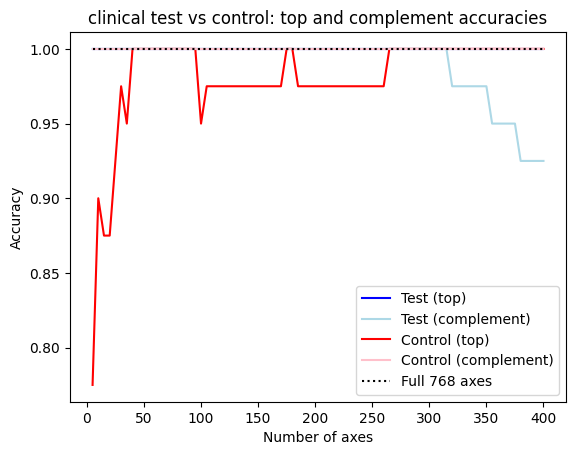

In [44]:
subslice_top_vals = [((i+1)*5) for i in range(range_val)]

# plot the top and complement accuracies for subslice as two lines on the same plot
# shift the x axis by 1 to account for the fact that the first subslice is 1
# plot the 768 accuracy as a dotted line as baseline
# light blue for top, dark blue for complement
plt.plot(subslice_top_vals, test_s5_top_accs, label='Test (top)', c='blue')
plt.plot(subslice_top_vals, test_s5_complement_accs, label='Test (complement)', c='lightblue')
plt.plot(subslice_top_vals, control_s5_top_accs, label='Control (top)', c='red')
plt.plot(subslice_top_vals, control_s5_complement_accs, label='Control (complement)', c='pink')
plt.plot([subslice_top_vals[0], subslice_top_vals[-1]], [full_acc, full_acc], ':', label='Full 768 axes', c='black')
plt.title(f'{classification} test vs control: top and complement accuracies')
plt.xlabel('Number of axes')
plt.ylabel('Accuracy')
plt.legend()
plt.show()